1. 모듈 임포트 & 사전 학습된 모델 선택

In [31]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet50, ResNet18_Weights, ResNet50_Weights
from torchinfo import summary

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt



In [32]:
WEIGHTS = ResNet18_Weights.DEFAULT
WEIGHTS

ResNet18_Weights.IMAGENET1K_V1

In [33]:
DATA_DIR_TRAIN ='../group4/data/train/'
DATA_DIR_VAL ='../group4/data/valid/'
PREPROCESSING = WEIGHTS.transforms()


print(PREPROCESSING)


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


2. 데이터 불러오기 & 라벨 매핑

In [34]:
imgDS = ImageFolder(root=DATA_DIR_TRAIN, transform=PREPROCESSING)

IDX_TO_CLASS = {v:k for k, v in imgDS.class_to_idx.items()}
print(f'IDX_TO_CLASS => {IDX_TO_CLASS}')

IDX_TO_CLASS => {0: 'cheetah', 1: 'hyena', 2: 'tiger'}


In [35]:
print(f'imgDataset 개수 : {len(imgDS.targets)}개')
print(f'imgDataset 분류 : {imgDS.class_to_idx}')
print(f'- cheetah     개수 : {imgDS.targets.count(0)}개, {(imgDS.targets.count(0)/len(imgDS.targets))*100}')
print(f'- hyena      개수 : {imgDS.targets.count(1)}개, {(imgDS.targets.count(1)/len(imgDS.targets))*100}')
print(f'- tiger      개수 : {imgDS.targets.count(2)}개, {(imgDS.targets.count(2)/len(imgDS.targets))*100}')


imgDataset 개수 : 2700개
imgDataset 분류 : {'cheetah': 0, 'hyena': 1, 'tiger': 2}
- cheetah     개수 : 900개, 33.33333333333333
- hyena      개수 : 900개, 33.33333333333333
- tiger      개수 : 900개, 33.33333333333333


 3. 이미지/라벨 샘플 확인

In [36]:
img,label = imgDS[0]
print(f'img { img.shape}, label {label}')

img torch.Size([3, 224, 224]), label 0


 4. Resnet 모델 로딩 및 구조 분석

In [37]:
## 인스턴스 생성해서 객체 확인하기 - 전체 계층 보려면 model만 print
model = resnet18(weights=WEIGHTS)

layer = model.fc 
# Linear(in_features=512, out_features=1000, bias=True) 이거 3으로로

for name, _ in model.named_children():
	print(name) # 모델의 층 별 이름만 추출 
print('-'*50)
print(f'출력층 {layer}')


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
--------------------------------------------------
출력층 Linear(in_features=512, out_features=1000, bias=True)


5. 3중 Classification을 위한 레이어 수정

In [38]:


"""
layer = 
Linear(in_features=512, out_features=1000, bias=True)
=> 이제 여기에서 out_features를 1000에서 3로 바꿈

"""

model.fc = nn.Linear(512, 3)


In [39]:
## 구조 전체 계층 다시 확인하기 출력 3으로 바뀐거
for name, param in model.named_parameters():
    if name.startswith("fc"):
        print(name, param.shape)




fc.weight torch.Size([3, 512])
fc.bias torch.Size([3])


특징 업데이트 설정

In [40]:
# 1. 특징 추출기 (conv1~layer4) freeze
for name, param in model.named_parameters():
    if name.startswith(("conv1", "bn1", "layer")):
        param.requires_grad = False

# 2. 분류기 (fc)만 학습 허용
for name, param in model.named_parameters():
    if name.startswith("fc"):
        param.requires_grad = True
        
## 확인인
for name, param in model.named_parameters():
    print(f"{name:40} requires_grad={param.requires_grad}")



conv1.weight                             requires_grad=False
bn1.weight                               requires_grad=False
bn1.bias                                 requires_grad=False
layer1.0.conv1.weight                    requires_grad=False
layer1.0.bn1.weight                      requires_grad=False
layer1.0.bn1.bias                        requires_grad=False
layer1.0.conv2.weight                    requires_grad=False
layer1.0.bn2.weight                      requires_grad=False
layer1.0.bn2.bias                        requires_grad=False
layer1.1.conv1.weight                    requires_grad=False
layer1.1.bn1.weight                      requires_grad=False
layer1.1.bn1.bias                        requires_grad=False
layer1.1.conv2.weight                    requires_grad=False
layer1.1.bn2.weight                      requires_grad=False
layer1.1.bn2.bias                        requires_grad=False
layer2.0.conv1.weight                    requires_grad=False
layer2.0.bn1.weight     

<hr>

이제 학습 준비

In [41]:
## 학습 관련 설정 값
batch_size= 32
learning_rate= 0.0001
epochs= 10

transforms=PREPROCESSING

In [42]:
## 데이터 로드 - 아까 IMGDS로 확인했으니 
trainDS = ImageFolder(root=DATA_DIR_TRAIN, transform=transforms)
testDS = ImageFolder(root=DATA_DIR_VAL, transform=transforms)

trainDL = DataLoader(trainDS, batch_size=batch_size, shuffle=True,generator=torch.Generator().manual_seed(42))
testDL = DataLoader(testDS, batch_size=batch_size, shuffle=False, drop_last=True)


In [43]:
from collections import Counter

targets = trainDS.targets  
counter = Counter(targets)

print(f"\n[Train] 전체 데이터셋 개수: {len(targets)}개")
for cls_idx, count in sorted(counter.items()):
    class_name = IDX_TO_CLASS[cls_idx]
    percent = count / len(targets) * 100
    print(f"- {class_name:<10} 개수: {count:3}개, 비율: {percent:.2f}%")



targets = testDS.targets  
counter = Counter(targets)

print(f"\n[Test] 전체 데이터셋 개수: {len(targets)}개")
for cls_idx, count in sorted(counter.items()):
    class_name = IDX_TO_CLASS[cls_idx]
    percent = count / len(targets) * 100
    print(f"- {class_name:<10} 개수: {count:3}개, 비율: {percent:.2f}%")




[Train] 전체 데이터셋 개수: 2700개
- cheetah    개수: 900개, 비율: 33.33%
- hyena      개수: 900개, 비율: 33.33%
- tiger      개수: 900개, 비율: 33.33%

[Test] 전체 데이터셋 개수: 300개
- cheetah    개수: 100개, 비율: 33.33%
- hyena      개수: 100개, 비율: 33.33%
- tiger      개수: 100개, 비율: 33.33%


In [44]:
## 학습 관련 인스턴스들 생성

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)  


In [45]:
## 학습 관련 함수들
## - 학습
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 통계
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total * 100
    avg_loss = running_loss / len(dataloader)
    return avg_loss, acc



In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score
## - 검증
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / total * 100
    avg_loss = running_loss / len(dataloader)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, acc, precision, recall, f1



학습 진행

[Epoch 1]
Train Loss: 0.3079, Train Acc: 91.33%
Test  Loss: 0.0637, Acc: 99.65%, Precision: 1.00, Recall: 1.00, F1-score: 1.00

[Epoch 2]
Train Loss: 0.0708, Train Acc: 99.04%
Test  Loss: 0.0339, Acc: 99.65%, Precision: 1.00, Recall: 1.00, F1-score: 1.00

[Epoch 3]
Train Loss: 0.0403, Train Acc: 99.44%
Test  Loss: 0.0257, Acc: 99.65%, Precision: 1.00, Recall: 1.00, F1-score: 1.00

[Epoch 4]
Train Loss: 0.0353, Train Acc: 99.37%
Test  Loss: 0.0219, Acc: 99.65%, Precision: 1.00, Recall: 1.00, F1-score: 1.00

[Epoch 5]
Train Loss: 0.0261, Train Acc: 99.63%
Test  Loss: 0.0200, Acc: 99.65%, Precision: 1.00, Recall: 1.00, F1-score: 1.00

[Epoch 6]
Train Loss: 0.0231, Train Acc: 99.70%
Test  Loss: 0.0186, Acc: 99.65%, Precision: 1.00, Recall: 1.00, F1-score: 1.00

[Epoch 7]
Train Loss: 0.0186, Train Acc: 99.63%
Test  Loss: 0.0193, Acc: 99.65%, Precision: 1.00, Recall: 1.00, F1-score: 1.00

 개선 없음 (1회)

 조기 종료 triggered (Epoch 7)


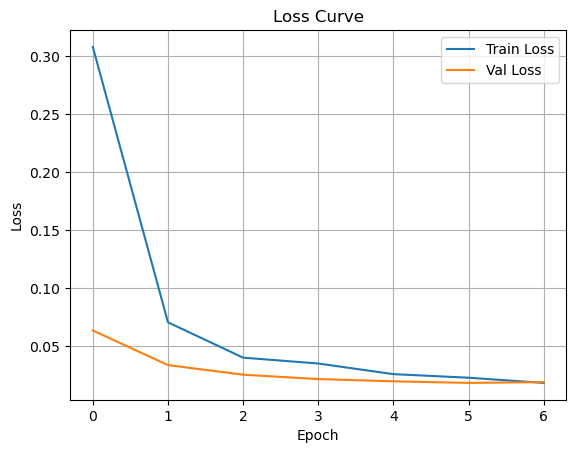

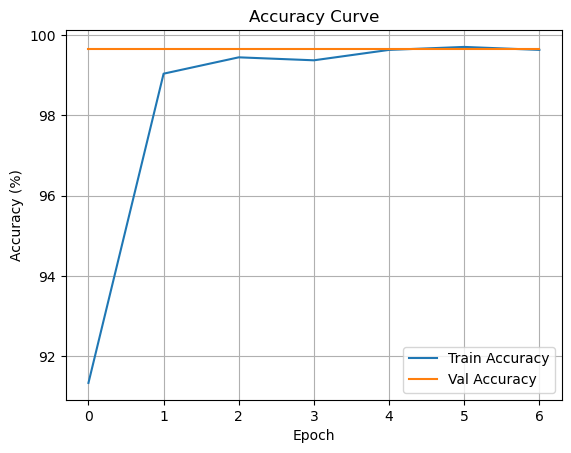

In [47]:

# 에폭별 기록 저장용 리스트
train_losses = []
val_losses = []
train_accs = []
val_accs = []
precisions = []
recalls = []
f1s = []

# 조기 종료 기준
patience = 1
best_val_loss = float('inf')
epochs_without_improvement = 0

# 학습 루프
for epoch in range(epochs):
    train_loss, train_acc = train(model, trainDL, criterion, optimizer, device)
    val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate(model, testDL, criterion, device)

    # 기록 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    precisions.append(val_precision)
    recalls.append(val_recall)
    f1s.append(val_f1)

    # 출력
    print(f"[Epoch {epoch+1}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test  Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, "
          f"Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1-score: {val_f1:.2f}\n")

    # 조기 종료 조건
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pt')
        # print("Best model 저장됨.\n")
    else:
        epochs_without_improvement += 1
        print(f" 개선 없음 ({epochs_without_improvement}회)")

        if epochs_without_improvement >= patience:
            print(f"\n 조기 종료 triggered (Epoch {epoch+1})")
            break

# ========================
#  에폭별 그래프 시각화
# ========================

# 손실 그래프
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# 정확도 그래프
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()





테스트 이미지 예측

In [48]:
from PIL import Image


img_path = r"D:\KDT8_Trans\TEANSFER_LEARNING\group4\data\valid\tiger\tiger_054_val_resized.jpg"  
img = Image.open(img_path).convert("RGB")


input_tensor = transforms(img).unsqueeze(0).to(device)

# 예측
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    _, pred = torch.max(output, 1)



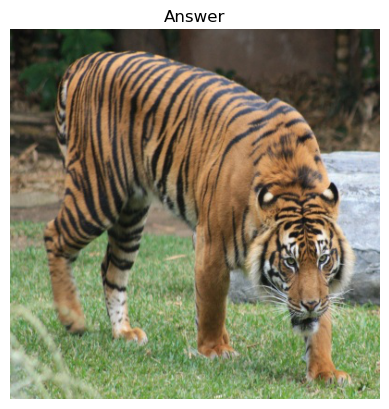

예측 결과: tiger


In [49]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title("Answer")
plt.axis('off')
plt.show()
# 결과 출력
print("예측 결과:", IDX_TO_CLASS[pred.item()])



<hr>

C:\Users\KDP-48\AppData\Local\Temp\ipykernel_2676\40897176.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_location

예측 클래스: hyena


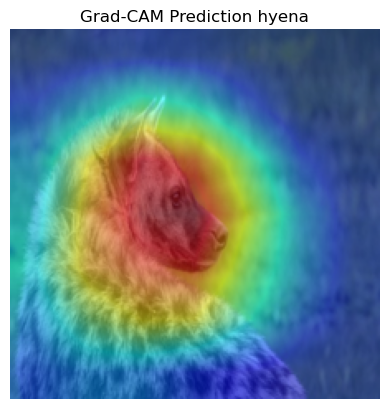

In [50]:
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 모델 로딩
model = resnet18(weights=None)
model.fc = torch.nn.Linear(512, 3)  # 클래스 수에 맞게
model.load_state_dict(torch.load("best_model.pt", map_location='cpu'))
model.eval()

IDX_TO_CLASS = {0: "cheetah", 1: "hyena", 2: "tiger"}

# 이미지 로드
img_path = r"D:\KDT8_Trans\TEANSFER_LEARNING\group4\data\valid\hyena\hyena_011_val_resized.jpg"  
img = Image.open(img_path).convert("RGB")

# 전처리
transform = PREPROCESSING
input_tensor = transform(img).unsqueeze(0)  # [1, 3, 224, 224]

# Grad-CAM 타깃 계층 설정 (보통 마지막 레이어)
target_layer = model.layer4[-1]

# 예측
output = model(input_tensor)
pred_class = output.argmax().item()
print("예측 클래스:", IDX_TO_CLASS[pred_class])

# Grad-CAM 실행
targets = [ClassifierOutputTarget(pred_class)]
with GradCAM(model=model, target_layers=[target_layer]) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# 시각화
rgb_image = input_tensor.squeeze().permute(1, 2, 0).numpy()
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

plt.imshow(cam_image)
plt.axis('off')
plt.title(f"Grad-CAM Prediction {IDX_TO_CLASS[pred_class]}")
plt.show()
